In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alicolak46/catvsdog

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/alicolak46/catvsdog
License(s): apache-2.0
 99% 415M/418M [00:29<00:00, 19.8MB/s]
100% 418M/418M [00:29<00:00, 14.9MB/s]


In [ ]:
! 7z x catvsdog.zip -o/content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 438351820 bytes (419 MiB)

Extracting archive: catvsdog.zip
 20% 4096 Open              --
Path = catvsdog.zip
Type = zip
Physical Size = 438351820

  0%      2% 547 - CatvsDog/test/cat/1969.jpg                                       4% 947 - CatvsDog/test/cat/2681.jpg                                       6% 1290 - CatvsDog/test/dog/113.jpg                                       8% 1808 - CatvsDog/test/dog/207.jpg              

**preprocessing dataset**

In [ ]:
import pathlib
data_dir=pathlib.Path('/content/CatvsDog/train')

data_image_dict={
    "cat":list(data_dir.glob('cat/*')),
}

import cv2
from PIL import Image

X=[]
for name,images in data_image_dict.items():
  for image in images:
    try:
      img=cv2.imread(str(image))
      resized_img=cv2.resize(img,(180,180))
      resized_img=(resized_img/255.0).astype(tf.float32)
    except:
      pass
    X.append(resized_img)

In [ ]:
X

[array([[[ 61,  95, 115],
         [ 60,  98, 118],
         [ 57, 100, 118],
         ...,
         [ 15,  17,  17],
         [ 14,  16,  16],
         [ 13,  15,  15]],
 
        [[ 59,  91, 109],
         [ 61,  97, 114],
         [ 58, 100, 117],
         ...,
         [ 17,  19,  19],
         [ 16,  18,  18],
         [ 15,  17,  17]],
 
        [[ 54,  83,  98],
         [ 56,  90, 105],
         [ 57,  97, 111],
         ...,
         [ 15,  17,  17],
         [ 14,  16,  16],
         [ 13,  15,  15]],
 
        ...,
 
        [[ 43,  71,  88],
         [ 43,  71,  88],
         [ 43,  71,  88],
         ...,
         [ 53,  90, 117],
         [ 51,  88, 115],
         [ 50,  87, 113]],
 
        [[ 43,  71,  88],
         [ 43,  71,  88],
         [ 43,  71,  88],
         ...,
         [ 55,  90, 116],
         [ 55,  90, 116],
         [ 55,  90, 116]],
 
        [[ 43,  71,  88],
         [ 43,  71,  88],
         [ 43,  71,  88],
         ...,
         [ 54,  88, 115],
  

In [ ]:
import numpy as np
try:
  X=np.array(X)
except:
  pass
X

array([[[[ 61,  95, 115],
         [ 60,  98, 118],
         [ 57, 100, 118],
         ...,
         [ 15,  17,  17],
         [ 14,  16,  16],
         [ 13,  15,  15]],

        [[ 59,  91, 109],
         [ 61,  97, 114],
         [ 58, 100, 117],
         ...,
         [ 17,  19,  19],
         [ 16,  18,  18],
         [ 15,  17,  17]],

        [[ 54,  83,  98],
         [ 56,  90, 105],
         [ 57,  97, 111],
         ...,
         [ 15,  17,  17],
         [ 14,  16,  16],
         [ 13,  15,  15]],

        ...,

        [[ 43,  71,  88],
         [ 43,  71,  88],
         [ 43,  71,  88],
         ...,
         [ 53,  90, 117],
         [ 51,  88, 115],
         [ 50,  87, 113]],

        [[ 43,  71,  88],
         [ 43,  71,  88],
         [ 43,  71,  88],
         ...,
         [ 55,  90, 116],
         [ 55,  90, 116],
         [ 55,  90, 116]],

        [[ 43,  71,  88],
         [ 43,  71,  88],
         [ 43,  71,  88],
         ...,
         [ 54,  88, 115],
        

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(X).batch(BATCH_SIZE)

## generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Adjust the Dense layer to match the upscaling size
    model.add(layers.Dense(45*45*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to (45, 45, 256)
    model.add(layers.Reshape((45, 45, 256)))
    assert model.output_shape == (None, 45, 45, 256)  # None is the batch size

    # First Conv2DTranspose layer, no change in size (45, 45, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 45, 45, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upscale to (90, 90, 64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 90, 90, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upscale to (180, 180, 1)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 180, 180, 3)

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


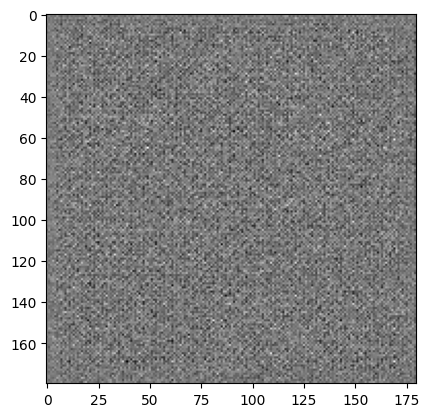

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## critic

In [ ]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[180, 180, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
critic = make_critic_model()
decision = critic(generated_image)
print (decision)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00059539]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def critic_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop()
critic_optimizer = tf.keras.optimizers.RMSprop()

In [ ]:
checkpoint_dir = './training_checkpoints3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=critic_optimizer,
                                 generator=generator,
                                 discriminator=critic)

In [ ]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = critic(images, training=True)
      fake_output = critic(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = critic_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, critic.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    critic_optimizer.apply_gradients(zip(gradients_of_discriminator, critic.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)